In [2]:
# IMPORT LIBRARY

#basic librairy
import numpy
import pandas
import xarray
import matplotlib.pyplot
import time

#for plotting 
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
from pyrolite.util.time import Timescale
ts = Timescale()

#dialog with Windows
#from tkinter import*
#from tkinter import filedialog

#for the Qt window
import sys
from PySide6.QtWidgets import QApplication, QMainWindow, QComboBox, QPushButton, QHBoxLayout, QVBoxLayout, QWidget, QLabel, QLineEdit, QMessageBox
from PySide6.QtGui import QFont
from PySide6.QtCore import Qt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg
from matplotlib.backends.backend_qt5 import NavigationToolbar2QT as NavigationToolbar
from magicgui.backends._qtpy import show_file_dialog


In [2]:
# === SUB FUNCTION === #

def get_chemin (n, tab_destination, dataframe, dataframe_2, max_p, nb_p, column):
    if nb_p == max_p:
        tab_destination[n,:,0]=dataframe.Time
        tab_destination[n,:,1]=dataframe[column]
    else:
        data_temp = dataframe.Time
        tab_destination[n,:,0]=numpy.pad(data_temp, (0 ,max_p-nb_p), 'constant', constant_values='nan')
        data_temp = dataframe[column]
        tab_destination[n,:,1]=numpy.pad(data_temp, (0 ,max_p-nb_p), 'constant', constant_values='nan')
    if isinstance(dataframe_2, pandas.DataFrame):
        tab_destination[n,1,2]=dataframe_2.iloc[0].Like
        tab_destination[n,2,2]=dataframe_2.iloc[0].Posterior
        
def get_He (n, echant_nom, nb_He, tab_destination, dataframe, filtre):
    
    a = dataframe[dataframe.Nom.str.contains('He_' + echant_nom) & dataframe.type.str.contains(filtre) & dataframe.type_bis.str.contains('1')].Pred_ages
    b = nb_He-len(a)

    #pred Ages
    data_temp = dataframe[dataframe.Nom.str.contains('He_' + echant_nom) & dataframe.type.str.contains(filtre) & dataframe.type_bis.str.contains('1')].Pred_ages
    tab_destination[n,:,0] = numpy.pad(data_temp, (0 ,b), 'constant', constant_values='nan')
    #error
    data_temp = ''
    tab_destination[n,:,1] = numpy.pad(data_temp, (0 ,nb_He), 'constant', constant_values='nan')
    #obs Ages
    data_temp = dataframe[dataframe.Nom.str.contains('He_' + echant_nom) & dataframe.type.str.contains(filtre) & dataframe.type_bis.str.contains('1')].Obs_age
    tab_destination[n,:,2] = numpy.pad(data_temp, (0 ,b), 'constant', constant_values='nan')
    #error
    data_temp = dataframe[dataframe.Nom.str.contains('He_' + echant_nom) & dataframe.type.str.contains(filtre) & dataframe.type_bis.str.contains('1')].Error
    tab_destination[n,:,3] = numpy.pad(data_temp, (0 ,b), 'constant', constant_values='nan')
    #Rs
    data_temp = dataframe[dataframe.Nom.str.contains('He_' + echant_nom) & dataframe.type.str.contains(filtre) & dataframe.type_bis.str.contains('1')].Rs
    tab_destination[n,:,4] = numpy.pad(data_temp, (0 ,b), 'constant', constant_values='nan')
    #Tc
    data_temp = dataframe[dataframe.Nom.str.contains('He_' + echant_nom) & dataframe.type.str.contains(filtre) & dataframe.type_bis.str.contains('1')].Tc
    tab_destination[n,:,5] = numpy.pad(data_temp, (0 ,b), 'constant', constant_values='nan')
    #eU
    data_temp = dataframe[dataframe.Nom.str.contains('He_' + echant_nom) & dataframe.type.str.contains(filtre) & dataframe.type_bis.str.contains('1')].eU
    tab_destination[n,:,6] = numpy.pad(data_temp, (0 ,b), 'constant', constant_values='nan')
    #Pred Ages (Corr)
    data_temp = dataframe[dataframe.Nom.str.contains('He_' + echant_nom) & dataframe.type.str.contains(filtre) & dataframe.type_bis.str.contains('1')].Cor_Pred_age
    tab_destination[n,:,7] = numpy.pad(data_temp, (0 ,b), 'constant', constant_values='nan')

def get_scale (maximum):
    maximum=int(maximum)
    if maximum >= 1000:
        max_scale = 250
        min_scale = 50
    elif 1000 > maximum >= 250 :
        max_scale = 100
        min_scale = 25
    elif 250 > maximum >= 100 :
        max_scale = 50
        min_scale = 10
    elif 100 > maximum >= 25 :
        max_scale = 25
        min_scale = 5
    elif 25 > maximum >= 15 :
        max_scale = 5
        min_scale = 1
    elif 15 > maximum >= 2 :
        max_scale = 2
        min_scale = 0.25
    else:
        max_scale = 0.5
        min_scale = 0.05
    
    return max_scale, min_scale

def get_file(*, racine='', multiple=False):
    # Create Tk root
    root = Tk()
    # Hide the main window
    root.withdraw()
    root.call('wm', 'attributes', '.', '-topmost', True)
    
    filepath = filedialog.askopenfilename(initialdir = racine,
                                          title="Open 'Summary.txt' file from QTQt",
                                          filetypes= (("text files","*.txt"),("all files","*.*")),
                                          multiple= multiple)
    root.destroy()
    
    return filepath

def get_path(*, name='', extension='svg', racine=''):
    # Create Tk root
    root = Tk()
    # Hide the main window
    root.withdraw()
    root.call('wm', 'attributes', '.', '-topmost', True)
    
    path = filedialog.asksaveasfile(initialfile = name,
                                          defaultextension = extension,
                                          filetypes=[("All Files","*.*")],
                                         )
    root.destroy()
    
    return path

def save_QTQt_fig (filepath, file_format, *,autopath=False):
    if autopath == False:
        file_name = filepath.replace(" ","_")
        test = file_name.split('/')
        file_name = test[len(test)-1]
        file_name = file_name.replace(".txt",'')
        complete_path = get_path(name= file_name, extension=file_format)
        complete_path = str(complete_path)
        complete_path = complete_path.replace("<_io.TextIOWrapper name='",'').replace("' mode='w' encoding='cp1252'>", '')
    else:
        complete_path = filepath.replace(".txt",'.' + file_format)
        
    figure.savefig(complete_path, format=file_format, bbox_inches='tight')
        

In [3]:
# === GET SAMPLES ===

def get_colorlist(data):
    nb_file = int(data.iloc[0])
    files = data[1 : nb_file + 1]
    #files = files.squeeze()

    for index, row in files.iterrows():
        #row = row.str.replace(".txt","")
        row = row.str.replace(" ","_")
        test_1 = row.str.split(pat='/',n=-1, expand=True)
        test_2 = test_1[test_1.shape[1]-1].values
        nom_ech = test_2[0].split('.txt')
        files.loc[index,:] = nom_ech[0]

    color_list = {}
    sample_list ={}
    n=1
    for item, value in matplotlib.colors.BASE_COLORS.items():
        if n > nb_file:
            pass
        else:
            nom = str(files.loc[n].values).replace("(",'').replace(")",'').replace("[","").replace("]","").replace("'","").replace(".txt","").replace("_"," ")
            color_list[nom] = value
            sample_list[n - 1] = nom
            n=n+1
            
    return color_list, sample_list


In [4]:
# === GET INFO ===

def get_inversion_info(data):
    
    info_list = {}
    
    #info recuperation
    
    info_loc1 = data[data[data.columns[0]].str.contains('Monitoring')]
    info_1 = data[info_loc1.index[0]+1 : info_loc1.index[0]+2]
    info_1 = info_1.squeeze()
    info_1 = info_1.replace(' =', '_=').replace('  ', ' ')
    info_1 = info_1.split(' ')
    info_2 = data[info_loc1.index[0]+2 : info_loc1.index[0]+3]
    info_2 = info_2.squeeze()
    info_2 = info_2.replace(' =', '_=').replace('#IO ', ' #IO').replace('  -nan', '-nan').replace('  ', ' ')
    info_2 = info_2.split(' ')
    
    info_loc2 = data[data[data.columns[0]].str.contains('Max allowable dTdt')]
    info_3 = data[info_loc2.index[0] : info_loc2.index[0]+1]
    info_3 = info_3.squeeze()
    info_3 = info_3.replace(' =', '_=').replace('  ', ' ')
    info_3 = info_3.split(' ')
    
    info_loc3 = data[data[data.columns[0]].str.contains('AdaptiveTimestep')]
    info_4 = data[info_loc3.index[0]+1 : info_loc3.index[0]+2]
    info_4 = info_4.squeeze()
    info_4 = info_4.replace(' =', '_=').replace('  ', ' ')
    info_4 = info_4.split(' ')
    info_5 = data[info_loc3.index[0]+2 : info_loc3.index[0]+3]
    info_5 = info_5.squeeze()
    info_5 = info_5.replace(' =', '_=').replace('  ', ' ')
    info_5 = info_5.split(' ')
    
    info_6 = data.iloc[-2]
    info_6 = info_6.squeeze()
    info_6 = info_6.split(' ')
    info_7 = data.iloc[-1]
    info_7 = info_7.squeeze()
    info_7 = info_7.split(' ')
    
    info_loc4 = data[data[data.columns[0]].str.contains('Move 1 :')]
    info_8 = data[info_loc4.index[0] : info_loc4.index[0]+11]
    info_8 = info_8.squeeze()
    info_8 = info_8.str.split(n=-1, expand=True)
    info_8.rename(columns={4:"nb_prop", 5:"ratio_prop", 7:"nb_accep", 8:"ratio_accep"},inplace=True)
    
    #info association
    info_list['Thinning'] =int(info_1[5])
    if int(info_1[8]) == 0:
        info_list['Gaussian exploration'] = 'no'
    else:
        info_list['Gaussian exploration'] = 'yes'
    if int(info_1[11]) == 0:
        info_list['Keep complex history'] = 'yes'
    else:
        info_list['Keep complex history'] = 'no'
        
    if 'nan' in info_2[5]:
        info_list['offset gaussian'] = 0
    else:
        info_list['offset gaussian'] = round(float(info_2[5]),0)
    info_list['time gaussian'] = float(info_2[1])
    info_list['temperature gaussian'] = float(info_2[3])
    info_list['FT resample'] = float(info_2[16])
    info_list['He resample'] = float(info_2[19])
    info_list['VR resample'] = float(info_2[22])
    
    if int(info_3[6]) == 0:
        info_list['allow reheating'] = 'yes'
    else:
        info_list['allow reheating'] = 'no'
    info_list['Max allowable dTdt'] = float(info_3[3])
    info_list['Rate tolerance'] = float(info_3[9])
    
    info_list['Temperature steps diffusion Ap'] = float(info_4[5])
    info_list['Temperature steps diffusion Other'] = float(info_4[8])
    info_list['Temperature steps radi dam Ap'] = float(info_5[6])
    info_list['Temperature steps radi dam Other'] = float(info_5[9])
    
    if round(float(info_6[0]),0)/60/60 >= 1:
        info_list['time burnin'] = str(round(float(info_6[0])/60/60,1)) + ' h.'
    else:
        info_list['time burnin'] = str(round(float(info_6[0])/60)) + ' min.'
        
    if round(float(info_7[0]),0)/60/60 >= 1:
        info_list['time total'] = str(round(float(info_7[0])/60/60,1)) + ' h.'
    else:
        info_list['time total'] = str(round(float(info_7[0])/60)) + ' min.'
        
    info_list['Acceptance time'] = round(float(info_8.ratio_accep.iloc[0]) * 100) 
    info_list['Acceptance temperature'] = round(float(info_8.ratio_accep.iloc[1]) * 100)
    if '-' in info_8.ratio_accep.iloc[2]:
        info_list['Acceptance offset'] = 0
    else:
        info_list['Acceptance offset'] = round(float(info_8.ratio_accep.iloc[2]) * 100)
    
    info_list['Acceptance Birth'] = round(float(info_8.ratio_accep.iloc[3]) * 100)
    info_list['Acceptance Death'] = round(float(info_8.ratio_accep.iloc[4]) * 100)
    
    info_list['Acceptance FT'] = round(float(info_8.ratio_accep.iloc[5]) * 100)
    info_list['Acceptance He'] = round(float(info_8.ratio_accep.iloc[6]) * 100)
    info_list['Acceptance Vitr'] = round(float(info_8.ratio_accep.iloc[7]) * 100)
    
    return info_list


In [5]:
# === CHAIN === # def extract_tT_history(data, data_tT)

def extract_tT_history(data):
    
    Chain_loc = data[data[data.columns[0]].str.contains('CHAIN')]
    Chain = data[Chain_loc.index[0]+1 : Chain_loc.index[1]-1]
    Chain = Chain.squeeze()
    Chain_tab = Chain.str.split(n=-1, expand=True)
    Chain_tab.rename(columns={0:"Step",1:"Likelihood",2:"Posterior",3:"nb_point"},inplace=True)
    Chain_tab = Chain_tab.apply(pandas.to_numeric, errors='coerce')
    Chain_tab = Chain_tab.round(2)
    
    nb_ech = data.iloc[0].values

    # HISTOIRE : convertir le format QTQt vers un format utilsable en passant par un array 3D
    X = range(4) #time, temperature, Z, info iteration
    Y = range(Chain_tab.shape[1]-4)
    iteration = range(Chain_tab.shape[0])

    data_tT = xarray.DataArray(
        data=[[[numpy.nan for i in range(len(X))] for j in range(len(Y))] for k in range(len(iteration))],
        coords={'X': X, 'Y': Y, 'iteration': iteration},
        dims=('iteration','Y', 'X')
    )

    data_tT[:,0,3]=Chain_tab.Step
    data_tT[:,1,3]=Chain_tab.Likelihood
    data_tT[:,2,3]=Chain_tab.Posterior
    data_tT[:,3,3]=Chain_tab.nb_point

    #boucle dans les colonnes pour la recuperation
    i=0
    j=0
    if int(nb_ech) > 1:
        nb_data = 2
    else:
        nb_data = 1
        
    for column in Chain_tab.columns[4:]:
        data_tT[:,j,i]=Chain_tab[column]
        i = i+1
        if i > nb_data :
            i = 0
            j = j+1
    
    return data_tT


In [6]:
# === CONSTRAIN === # def extract_constrain(data, data_constrain)

def extract_constrain(data):
    constrain_loc = data[data[data.columns[0]].str.contains('Setting tt points 1 =')]

    test = constrain_loc.squeeze()
    constrain_nb = test.split(' ')
    constrain = data[constrain_loc.index[0]+1 : constrain_loc.index[0] + 1 + 1 + int(constrain_nb[5])]

    constrain_tab = constrain.squeeze()
    constrain_tab = constrain_tab.str.split(n=-1, expand=True)
    constrain_tab.rename(columns={0:"Time",1:"dTime",2:"Temp",3:"dTemp"},inplace=True)

    #recup dans un xarray
    X = range(4) #time, dtime, temperature, dtemperature
    Y = range(int(constrain_nb[5])+1)

    #data_tT.clear()
    data_constrain = xarray.DataArray(
        data=[[numpy.nan for i in range(len(X))] for j in range(len(Y))],
        coords={'constrain': X, 'info': Y},
        dims=('info', 'constrain')
    )

    i=0
    for index, row in constrain_tab.iterrows():
        data_constrain[i,0]=row.Time
        data_constrain[i,1]=row.dTime
        data_constrain[i,2]=row.Temp
        data_constrain[i,3]=row.dTemp
        i=i+1

    #retirer la derniere ligne (temperature actuel)
    data_constrain = numpy.delete(data_constrain,(i-1), axis=0)
    
    return data_constrain


In [7]:
# === PREDICTED t(T) === # def extract_tT_pred(data, data_Chemin)

def extract_tT_pred(data):
    max_point = 3
    
    #bloc 1
    Chemin_loc = data[data[data.columns[0]].str.contains('Max Like')]
    nb_point_like = data[Chemin_loc.index[0]+2 : Chemin_loc.index[0]+3].values
    Chemin_val = data[Chemin_loc.index[0]+1 : Chemin_loc.index[0] + 3]
    Chemin_val_like = Chemin_val.squeeze()
    Chemin_val_like = Chemin_val_like.str.split(n=-1, expand=True)
    Chemin_val_like.rename(columns={2:"Like",4:"Posterior"},inplace=True)
    Chemin_point = data[Chemin_loc.index[0]+3 : Chemin_loc.index[0] + 3 + int(nb_point_like)]
    Chemin_point_like = Chemin_point.squeeze()
    Chemin_point_like = Chemin_point_like.str.split(n=-1, expand=True)
    Chemin_point_like.rename(columns={0:"point",1:"Time",2:"Temp",3:"Z"},inplace=True)
    max_point = max(int(nb_point_like),max_point)
    
    #bloc 2
    Chemin_loc = data[data[data.columns[0]].str.contains('Max Post')]
    nb_point_post = data[Chemin_loc.index[0]+2 : Chemin_loc.index[0]+3].values
    Chemin_val = data[Chemin_loc.index[0]+1 : Chemin_loc.index[0] + 3]
    Chemin_val_post = Chemin_val.squeeze()
    Chemin_val_post = Chemin_val_post.str.split(n=-1, expand=True)
    Chemin_val_post.rename(columns={2:"Like",4:"Posterior"},inplace=True)
    Chemin_point = data[Chemin_loc.index[0]+3 : Chemin_loc.index[0] + 3 + int(nb_point_post)]
    Chemin_point_post = Chemin_point.squeeze()
    Chemin_point_post = Chemin_point_post.str.split(n=-1, expand=True)
    Chemin_point_post.rename(columns={0:"point",1:"Time",2:"Temp",3:"Z"},inplace=True)
    max_point = max(int(nb_point_post),max_point)
    
    #bloc 3
    Chemin_loc = data[data[data.columns[0]].str.contains('EXPECTED')]
    nb_point_expect = data[Chemin_loc.index[0]+3 : Chemin_loc.index[0]+4].values
    nb_point_expect = nb_point_expect[0,0].split(' ')
    Chemin_point = data[Chemin_loc.index[0]+4 : Chemin_loc.index[0] + 4 + int(nb_point_expect[0])]
    Chemin_point_expect = Chemin_point.squeeze()
    Chemin_point_expect = Chemin_point_expect.str.split(n=-1, expand=True)
    Chemin_point_expect.rename(columns={0:"Time",1:"T_Expected",2:"T_Mode",3:"T_env_sup",4:"T_env_inf"},inplace=True)
    max_point = max(int(nb_point_expect[0]),max_point)
    
    #recup dans un xarray
    X = range(3) #time, temperature, info
    Y = range(max_point)
    Chemin = range(6)
    #data_tT.clear()
    data_Chemin = xarray.DataArray(
        data=[[[numpy.empty for i in range(len(X))] for j in range(len(Y))] for k in range(len(Chemin))],
        coords={'X': X, 'Y': Y, 'Chemin': Chemin},
        dims=('Chemin','Y', 'X')
    )
    
    get_chemin (0, data_Chemin, Chemin_point_like,Chemin_val_like, max_point, int(nb_point_like), 'Temp')
    data_Chemin[0,0,2]='Max likelihood'
    get_chemin (1, data_Chemin, Chemin_point_post,Chemin_val_post, max_point, int(nb_point_post), 'Temp')
    data_Chemin[1,0,2]='Max posterior'
    get_chemin (2, data_Chemin, Chemin_point_expect, "",max_point, int(nb_point_expect[0]), 'T_Expected')
    data_Chemin[2,0,2]='Expected model'
    get_chemin (3, data_Chemin, Chemin_point_expect, "",max_point, int(nb_point_expect[0]), 'T_Mode')
    data_Chemin[3,0,2]='Max mode model'
    get_chemin (4, data_Chemin, Chemin_point_expect, "",max_point, int(nb_point_expect[0]), 'T_env_sup')
    data_Chemin[4,0,2]='Envelope sup. (99%)'
    get_chemin (5, data_Chemin, Chemin_point_expect, "",max_point, int(nb_point_expect[0]), 'T_env_inf')
    data_Chemin[5,0,2]='Envelope inf. (99%)'

    return data_Chemin

In [8]:
# === He AGES === # def extract_He_Ages(data, data_He_Maxlike, data_He_MaxPost, data_He_Expect):
         
def extract_He_Ages(data):
    # AGE : extraire du fichier Summary.txt les chemins
    He_Age_loc = data[data[data.columns[0]].str.contains('Max Like|Max Post|EXPECTED|File Name|He =|HeR')]
    nb_ech = int(data.loc[0])

    # nettoyage des echan sans helium
    nb_He = 0
    mem = ""
    mem_ech = 0
    mem_type = ""
    Expected = False
    mem_expected = 1
    for index, row in He_Age_loc.iterrows():
        if 'HeR =' in row[0]:
            He_Age_loc.loc[index,:] = row.str.replace("HeR =",'He_' + nom_ech)
            He_Age_loc.loc[index,:] = He_Age_loc.loc[index,:].str.replace("Pred Age", str(mem_type + " " + str(mem_expected)))

        if 'Max Like' in row[0]:
            mem_type = row[0] 
            He_Age_loc = He_Age_loc.drop(labels=[index], axis = 0)
        if 'Max Post' in row[0]:
            mem_type = row[0]  
            He_Age_loc = He_Age_loc.drop(labels=[index], axis = 0)
        if 'EXPECTED' in row[0]:
            mem_type = row[0]
            He_Age_loc = He_Age_loc.drop(labels=[index], axis = 0)
            Expected = True
            mem_expected = 0

        if 'File Name =' in row[0]:
            if Expected == True:
                mem_expected = mem_expected + 1
                if mem_expected > 2:
                    mem_expected = 1
            #row = row.str.replace(".txt","")
            row = row.str.replace(" ","_")
            test_1 = row.str.split(pat='/',n=-1, expand=True)
            nom_ech = str(test_1[test_1.shape[1]-1].values)
            nom_ech = nom_ech.replace("(",'').replace(")",'').replace("[","").replace("]","").replace("'","").replace(".txt","")
            He_Age_loc.loc[index,:] = nom_ech + " t " + mem_type + " " + str(mem_expected)
            mem_ech = mem_ech + 1
            if mem_ech > nb_ech:
                mem_ech = 1
                
        if 'NFT =' in row[0]:
            He_Age_loc = He_Age_loc.drop(labels=[index], axis = 0)
        elif 'He =' in row[0]:
            test = row.str.split(n=-1, expand=True)
            if int(test[2]) == 0:
                He_Age_loc = He_Age_loc.drop(labels=[mem, index], axis = 0)
            else:
                nb_He = max(nb_He,int(test[2]))
                He_Age_loc = He_Age_loc.drop(labels=[index], axis = 0)

        else:    
            mem = index
    
    if not He_Age_loc.empty:
        He_Age_loc = He_Age_loc.squeeze()
        He_Age_loc = He_Age_loc.str.replace("Max ","Max-")
        He_Age = He_Age_loc.str.split(n=-1, expand=True)
        He_Age.rename(columns={0:"Nom",1:"Rs",2:"type",3:"type_bis",5:"Pred_ages",9:"Obs_age",12:"Error",18:"Tc",22:"eU",25:"Ft",28:"Cor_Pred_age"},inplace=True)
        nb_ech = He_Age[He_Age.Rs.str.contains('t') & He_Age.type.str.contains('Max-Like')].Nom.shape[0]
        
        #recup des He
        X = range(9) #Rs, Pred Ages, ±, Obs Ages, ±, Tc, eU, Pred Ages (Corr), echantillon + info
        Y = range(nb_He)
        echantillon = range(nb_ech)

        #maxlike
        data_He_Maxlike = xarray.DataArray(
            data=[[[numpy.empty for i in range(len(X))] for j in range(len(Y))] for k in range(len(echantillon))],
            coords={'X': X, 'Y': Y, 'echantillon': echantillon},
            dims=('echantillon','Y', 'X')
        )
        #maxpost
        data_He_MaxPost = xarray.DataArray(
            data=[[[numpy.empty for i in range(len(X))] for j in range(len(Y))] for k in range(len(echantillon))],
            coords={'X': X, 'Y': Y, 'echantillon': echantillon},
            dims=('echantillon','Y', 'X')
        )
        #expect
        data_He_Expect = xarray.DataArray(
            data=[[[numpy.empty for i in range(len(X))] for j in range(len(Y))] for k in range(len(echantillon))],
            coords={'X': X, 'Y': Y, 'echantillon': echantillon},
            dims=('echantillon','Y', 'X')
        )

        data_He_Maxlike[:,0,8] = He_Age[He_Age.Rs.str.contains('t') & He_Age.type.str.contains('Max-Like')].Nom
        data_He_Maxlike[:,1,8] = He_Age[He_Age.Rs.str.contains('t') & He_Age.type.str.contains('Max-Like')].type
        data_He_MaxPost[:,0,8] = He_Age[He_Age.Rs.str.contains('t') & He_Age.type.str.contains('Max-Post')].Nom
        data_He_MaxPost[:,1,8] = He_Age[He_Age.Rs.str.contains('t') & He_Age.type.str.contains('Max-Post')].type
        data_He_Expect[:,0,8] = He_Age[He_Age.Rs.str.contains('t') & He_Age.type.str.contains('EXPECTED') & He_Age.type_bis.str.contains('1')].Nom
        data_He_Expect[:,1,8] = He_Age[He_Age.Rs.str.contains('t') & He_Age.type.str.contains('EXPECTED') & He_Age.type_bis.str.contains('1')].type

        for n in echantillon:
            ech = data_He_Maxlike[n,0,8].values
            get_He(n, ech ,nb_He, data_He_Maxlike, He_Age, 'Max-Like')
            get_He(n, ech ,nb_He, data_He_MaxPost, He_Age, 'Max-Post')
            get_He(n, ech ,nb_He, data_He_Expect, He_Age, 'EXPECTED')

        for n in echantillon:
            data_He_Maxlike[n,:,1] = data_He_Maxlike[n,:,3].astype(dtype=float) / data_He_Maxlike[n,:,2].astype(dtype=float) * data_He_Maxlike[n,:,0].astype(dtype=float)
            data_He_MaxPost[n,:,1] = data_He_MaxPost[n,:,3].astype(dtype=float) / data_He_MaxPost[n,:,2].astype(dtype=float) * data_He_MaxPost[n,:,0].astype(dtype=float)
            data_He_Expect[n,:,1] = data_He_Expect[n,:,3].astype(dtype=float) / data_He_Expect[n,:,2].astype(dtype=float) * data_He_Expect[n,:,0].astype(dtype=float)
        
        return data_He_Maxlike, data_He_MaxPost, data_He_Expect
    
    else:
        
        return '', '', ''

In [9]:
# === FT AGES === # def extract_He_Ages(data, data_He_Maxlike, data_He_MaxPost, data_He_Expect)

def extract_FT_Ages(data):
    
    FT_Age_loc = data[data[data.columns[0]].str.contains('Max Like|Max Post|EXPECTED|File Name|Pred FT age')]
    nb_ech = int(data.loc[0])
    # nettoyage des echan sans AFT
    mem_type = ""
    mem_nom = ""
    mem_expected = 0
    Expected = False
    for index, row in FT_Age_loc.iterrows():

        if 'Max Like' in row[0]:
            mem_type = row.str.replace(" ","_")
            FT_Age_loc = FT_Age_loc.drop(labels=[index], axis = 0)
        elif 'Max Post' in row[0]:
            mem_type = row.str.replace(" ","_")
            FT_Age_loc = FT_Age_loc.drop(labels=[index], axis = 0)
        elif 'EXPECTED' in row[0]:
            mem_type = row.str.replace(" ","_")
            FT_Age_loc = FT_Age_loc.drop(labels=[index], axis = 0)
            Expected = True   

        elif 'File Name =' in row[0]:
            if Expected == True:
                mem_expected = mem_expected + 1
                if mem_expected > 2:
                    mem_expected = 1
            
            #row = row.str.replace(".txt","")
            row = row.str.replace(" ","_")
            test = row.str.split(pat='/',n=-1, expand=True)
            mem_nom = str(test[test.shape[1]-1].values).replace("(",'').replace(")",'').replace("[","").replace("]","").replace("'","").replace(".txt","")
            FT_Age_loc = FT_Age_loc.drop(labels=[index], axis = 0)

        elif 'Pred FT age =' in row[0]:
            test = row.str.split(n=-1, expand=True)
            if float(test[5]) == -1:
                FT_Age_loc = FT_Age_loc.drop(labels=[index], axis = 0)
            else:
                FT_Age_loc.loc[index] = FT_Age_loc.loc[index].str.replace("Pred FT", mem_nom + " " + str(mem_type.values) + " " + str(mem_expected))

    if not FT_Age_loc.empty:
        FT_Age_tab = FT_Age_loc.squeeze()
        FT_Age_tab = FT_Age_tab.str.split(n=-1, expand=True)
        FT_Age_tab.rename(columns={0:"nom",1:"type",2:"expect",5:"Pred_ages",6:"Obs_ages",20:"Error"},inplace=True)
        nb_FT = FT_Age_tab[FT_Age_tab.type.str.contains('Max_Like')].nom.shape[0]

        #recup dans un xarray
        X = range(6) #Pred_ages, dpred, Obs_ages, dobs, nom, type
        Y = range(1)
        echantillon = range(int(nb_FT))

        #1
        data_FT_like = xarray.DataArray(
            data=[[[numpy.empty for i in range(len(X))] for j in range(len(Y))] for k in range(len(echantillon))],
            coords={'X': X, 'Y': Y, 'echantillon': echantillon},
            dims=('echantillon', 'Y', 'X')
        )
        #2
        data_FT_post = xarray.DataArray(
            data=[[[numpy.empty for i in range(len(X))] for j in range(len(Y))] for k in range(len(echantillon))],
            coords={'X': X, 'Y': Y, 'echantillon': echantillon},
            dims=('echantillon', 'Y', 'X')
        )
        #3
        data_FT_expect = xarray.DataArray(
            data=[[[numpy.empty for i in range(len(X))] for j in range(len(Y))] for k in range(len(echantillon))],
            coords={'X': X, 'Y': Y, 'echantillon': echantillon},
            dims=('echantillon', 'Y', 'X')
        )

        data_FT_like[:,0,0]=FT_Age_tab[FT_Age_tab.type.str.contains('Max_Like')].Pred_ages
        data_FT_like[:,0,1]=FT_Age_tab[FT_Age_tab.type.str.contains('Max_Like')].Obs_ages
        data_FT_like[:,0,2]=FT_Age_tab[FT_Age_tab.type.str.contains('Max_Like')].Error
        data_FT_like[:,0,4]=FT_Age_tab[FT_Age_tab.type.str.contains('Max_Like')].nom
        data_FT_like[:,0,5]=FT_Age_tab[FT_Age_tab.type.str.contains('Max_Like')].type

        data_FT_post[:,0,0]=FT_Age_tab[FT_Age_tab.type.str.contains('Max_Post')].Pred_ages
        data_FT_post[:,0,1]=FT_Age_tab[FT_Age_tab.type.str.contains('Max_Post')].Obs_ages
        data_FT_post[:,0,2]=FT_Age_tab[FT_Age_tab.type.str.contains('Max_Post')].Error
        data_FT_post[:,0,4]=FT_Age_tab[FT_Age_tab.type.str.contains('Max_Post')].nom
        data_FT_post[:,0,5]=FT_Age_tab[FT_Age_tab.type.str.contains('Max_Post')].type

        data_FT_expect[:,0,0]=FT_Age_tab[FT_Age_tab.type.str.contains('EXPECTED') & FT_Age_tab.expect.str.contains('1')].Pred_ages
        data_FT_expect[:,0,1]=FT_Age_tab[FT_Age_tab.type.str.contains('EXPECTED') & FT_Age_tab.expect.str.contains('1')].Obs_ages
        data_FT_expect[:,0,2]=FT_Age_tab[FT_Age_tab.type.str.contains('EXPECTED') & FT_Age_tab.expect.str.contains('1')].Error
        data_FT_expect[:,0,4]=FT_Age_tab[FT_Age_tab.type.str.contains('EXPECTED') & FT_Age_tab.expect.str.contains('1')].nom
        data_FT_expect[:,0,5]=FT_Age_tab[FT_Age_tab.type.str.contains('EXPECTED') & FT_Age_tab.expect.str.contains('1')].type


        data_FT_like[:,0,3] = data_FT_like[:,0,2].astype(dtype=float) / data_FT_like[:,0,1].astype(dtype=float) * data_FT_like[:,0,0].astype(dtype=float)
        data_FT_post[:,0,3] = data_FT_post[:,0,2].astype(dtype=float) / data_FT_post[:,0,1].astype(dtype=float) * data_FT_post[:,0,0].astype(dtype=float)
        data_FT_expect[:,0,3] = data_FT_expect[:,0,2].astype(dtype=float) / data_FT_expect[:,0,1].astype(dtype=float) * data_FT_expect[:,0,0].astype(dtype=float)

        return data_FT_like, data_FT_post, data_FT_expect
    
    else:
        return '', '', ''



In [10]:
# === FT LENGTH === # def extract_He_Ages(data, data_He_Maxlike, data_He_MaxPost, data_He_Expect)

def extract_FT_Length(data):
    FT_Length_loc = data[data[data.columns[0]].str.contains('Max Like|Max Post|EXPECTED|File Name|Lc0 = ')]

    mem_type = ""
    mem_nom = ""
    mem_expected = 0
    Expected = False
    for index, row in FT_Length_loc.iterrows():

        if 'Max Like' in row[0]:
            mem_type = row.str.replace(" ","_")
            FT_Length_loc = FT_Length_loc.drop(labels=[index], axis = 0)
        elif 'Max Post' in row[0]:
            mem_type = row.str.replace(" ","_")
            FT_Length_loc = FT_Length_loc.drop(labels=[index], axis = 0)
        elif 'EXPECTED' in row[0]:
            mem_type = row.str.replace(" ","_")
            FT_Length_loc = FT_Length_loc.drop(labels=[index], axis = 0)
            Expected = True   

        elif 'File Name =' in row[0]:
            if Expected == True:
                mem_expected = mem_expected + 1
                if mem_expected > 2:
                    mem_expected = 1

            #row = row.str.replace(".txt","")
            row = row.str.replace(" ","_")
            test = row.str.split(pat='/',n=-1, expand=True)
            mem_nom = test[test.shape[1]-1].values
            FT_Length_loc = FT_Length_loc.drop(labels=[index], axis = 0)

        elif 'Lc0 ='  in row[0]:
            FT_Length_loc.loc[index] = str(mem_nom[0]) + " " + mem_type.values + " " + str(mem_expected)

    FT_Length_tab = FT_Length_loc.squeeze()
    FT_Length_tab = FT_Length_tab.str.split(n=-1, expand=True)
    FT_Length_tab.rename(columns={0:"nom",1:"type",2:"expect"},inplace=True)
    nb_ech = FT_Length_tab[FT_Length_tab.type.str.contains('Max_Like')].nom.shape[0]
    
    #recup des He
    X = range(6) #lenght, nb_obs, nb_pred_maxlike, nb_pred_maxpost, nb_pred_maxexpected, info
    Y = range(200)
    echantillon = range(nb_ech)

    data_FT_Lenght = xarray.DataArray(
        data=[[[numpy.empty for i in range(len(X))] for j in range(len(Y))] for k in range(len(echantillon))],
        coords={'X': X, 'Y': Y, 'echantillon': echantillon},
        dims=('echantillon','Y', 'X')
    )

    for n in range(data_FT_Lenght.shape[0]):
        data_FT_Lenght[n,:,0]=numpy.arange(0,20, step=0.1)

    n=0

    for index, row in  FT_Length_tab[FT_Length_tab.type.str.contains('Max_Like')].iterrows():
        a = index
        obs_LFT = data[a - 20 : a -1 ]
        obs_LFT = obs_LFT.squeeze()
        obs_LFT = obs_LFT.str.split(n=-1, expand=True)
        obs_LFT.rename(columns={0:"lenght",1:"curve",2:"bar"},inplace=True)
        test = numpy.empty((19,10,))
        test_0 = numpy.empty((1,10,))
        test[:,:] = numpy.nan
        test_0[:,:] = numpy.nan
        
        test[:,0] = obs_LFT.bar
        test = numpy.concatenate((test_0, test))
        data_FT_Lenght[n,:,1] = test.ravel()

        pred_LFT = data[a + 1 : a +1 + 200]
        pred_LFT = pred_LFT.squeeze()
        pred_LFT = pred_LFT.str.split(n=-1, expand=True)
        pred_LFT.rename(columns={0:"number", 1:"lenght", 2:"curve"},inplace=True)
        data_FT_Lenght[n,:,2]=pred_LFT.curve

        data_FT_Lenght[n,0,5]=FT_Length_tab.loc[a].nom

        n=n+1

    n=0
    for index, row in  FT_Length_tab[FT_Length_tab.type.str.contains('Max_Post')].iterrows():
        a = index
        pred_LFT = data[a + 1 : a +1 + 200]
        pred_LFT = pred_LFT.squeeze()
        pred_LFT = pred_LFT.str.split(n=-1, expand=True)
        pred_LFT.rename(columns={0:"number", 1:"lenght", 2:"curve"},inplace=True)
        data_FT_Lenght[n,:,3]=pred_LFT.curve
        n=n+1

    n=0
    for index, row in FT_Length_tab[FT_Length_tab.expect.str.contains('1')].iterrows():   
        a = index
        pred_LFT = data[a + 1 : a +1 + 200]
        pred_LFT = pred_LFT.squeeze()
        pred_LFT = pred_LFT.str.split(n=-1, expand=True)
        pred_LFT.rename(columns={0:"number", 1:"lenght", 2:"curve"},inplace=True)
        data_FT_Lenght[n,:,4]=pred_LFT.curve
        n=n+1
    
    return data_FT_Lenght


In [11]:
# === FIG : plot_iteration === plot_iteration(data_tT):

def plot_iteration(data_tT, info_list):
    # === graphique du like ===
    plot_like.clear()
    x= data_tT[:,0,3]
    y= data_tT[:,1,3]
    plot_like.plot(x, y, color='red', linewidth = 0.5)

    # Defining the label
    # plot_post.text(x_max-(x_max-x_min)*0.40, y_min+(y_max-y_min)*0.1, 'total time : '+info_list['time total'], fontsize=7,style='italic')
    plot_like.set_xlabel('Exploration info.' + ' (' + info_list['time total'] +')')
    plot_like.set_ylabel('likelihood', style='italic', color= 'red')
    plot_like.xaxis.set_label_position('top') 
    plot_like.yaxis.set_label_position('right') 
    plot_like.tick_params(labelbottom=False, labeltop=True, labelleft=True, labelright=False)
    plot_like.tick_params(axis='x', labelrotation=20)
    plot_like.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: '{:,}'.format(int(x)).replace(",", " ")))
    # suppr border
    #plot_like.spines['right'].set_visible(False)
    plot_like.spines['bottom'].set_visible(False)

    plot_like.xaxis.set_tick_params(which='major' ,direction='inout',length=5 ,width=1 ,color='black' ,labelcolor='black' ,top=True ,bottom=True  )
    plot_like.xaxis.set_tick_params(which='minor' ,direction='in',length=2 ,width=0.5 ,color='black' ,labelcolor='black' ,top=True ,bottom=True  )

    plot_like.yaxis.set_tick_params(which='major' ,direction='inout',length=5 ,width=1 ,color='black' ,labelcolor='black' ,left=True ,right=False  )
    plot_like.yaxis.set_tick_params(which='minor' ,direction='in',length=2 ,width=0.5 ,color='black' ,labelcolor='black' ,left=True ,right=False  )

    # === graphique du Post ===
    plot_post.clear()
    x= data_tT[:,0,3]
    y_bis= data_tT[:,2,3]
    plot_post.plot(x, y_bis, color='blue', linewidth = 0.5)

    # Defining the label
    plot_post.tick_params(labelbottom=False, labeltop=False, labelleft=True, labelright=False )
    y_min, y_max = plot_post.get_ylim()
    x_min, x_max = plot_post.get_xlim()

    # Defining the label
    plot_post.set_ylabel('posterior', style='italic', color= 'blue')
    plot_post.yaxis.set_label_position('right') 
    plot_post.spines['bottom'].set_visible(True)
    plot_post.spines['top'].set_visible(False)

    plot_post.xaxis.set_tick_params(which='major' ,direction='inout',length=5 ,width=1 ,color='black' ,labelcolor='black' ,bottom=True ,top=False  )
    plot_post.xaxis.set_tick_params(which='minor' ,direction='in',length=2 ,width=0.5 ,color='black' ,labelsize='10' ,labelcolor='black' ,bottom=True ,top=False  )

    plot_post.yaxis.set_tick_params(which='major' ,direction='inout',length=5 ,width=1 ,color='black' ,labelcolor='black' ,left=True ,right=False  )
    plot_post.yaxis.set_tick_params(which='minor' ,direction='in',length=2 ,width=0.5 ,color='black' ,labelcolor='black' ,left=True ,right=False  )


In [12]:
# === FIG : plot_pred_ages(data_He, data_FT) ===

def plot_pred_ages(tabl_He_like, tabl_He_post, tabl_He_expect, tabl_FT_like, tabl_FT_post, tabl_FT_expect, color_list,*, model='like'):
    
    plot_age.clear()
    
    if 'Post' in model:
        data_He = tabl_He_post
        data_FT = tabl_FT_post
        txt_info = 'max posterior'
    elif 'Expect' in model:
        data_He = tabl_He_expect
        data_FT = tabl_FT_expect
        txt_info = 'expected'
    elif 'Like' in model:
        data_He = tabl_He_like
        data_FT = tabl_FT_like
        txt_info = 'max likelihood'

    if len(data_He) !=0 :
        for i in range(data_He.shape[0]):
            x = data_He[i,:,2].astype(dtype=float)
            y = data_He[i,:,0].astype(dtype=float)
            dx = data_He[i,:,3].astype(dtype=float)
            dy = data_He[i,:,1].astype(dtype=float)
            nom = data_He[i,0,8].str.replace(".txt","").str.replace("_"," ")
            nom = str(nom.values)
            plot_age.scatter(x , y, s=30,
                             color=color_list[nom],
                             marker="o",
                             label=nom,
                             linewidths=0.5,
                             edgecolors = "black",
                             alpha=0.50)
            plot_age.errorbar(x , y, xerr=dx, yerr=dy, fmt="o", markersize=0, ecolor=color_list[nom])
    
    if len(data_FT) !=0 :
        for i in range(data_FT.shape[0]):
            x = data_FT[i,0,1].astype(dtype=float)
            y = data_FT[i,0,0].astype(dtype=float)
            dx = data_FT[i,0,3].astype(dtype=float)
            dy = data_FT[i,0,2].astype(dtype=float)
            nom = data_FT[i,0,4].str.replace(".txt","").str.replace("_"," ")
            nom = str(nom.values)
            plot_age.scatter(x , y, s=30,
                             color=color_list[nom],
                             marker="s",
                             label=nom,
                             linewidths=0.5,
                             edgecolors = "black",
                             alpha=0.50)
            plot_age.errorbar(x , y, xerr=dx, yerr=dy, fmt="s", markersize=0, ecolor=color_list[nom])

    y_min, y_max = plot_age.get_ylim()
    x_min, x_max = plot_age.get_xlim()
    
    plot_age.text(x_max*1.15, (y_max-y_min)/2+y_min, 'prediction : ' + txt_info, style='italic', rotation='vertical',verticalalignment='center')
    
    y_min = y_min * 0.9
    y_max = y_max * 1.1
    x_min = x_min * 0.9
    x_max = x_max * 1.1
    
    plot_age.axline((0, 0), slope=1, linewidth=0.5, color='black', alpha = 0.75, linestyle='--')
    legend_elements = [matplotlib.lines.Line2D([0], [0], marker='o', label='He', markeredgecolor='gray',markerfacecolor='w', color='w', markersize=5),
                       matplotlib.lines.Line2D([0], [0], marker='s', label='FT', markeredgecolor='gray',markerfacecolor='w', color='w', markersize=5)
                      ]
    plot_age.legend(handles=legend_elements, ncol=1, bbox_to_anchor=(0, 1), fontsize='x-small')

    plot_age.set_xlim(left=x_min, right=x_max)
    plot_age.set_ylim(bottom=y_min, top=y_max)

    plot_age.set_xlabel('Obs. ages [Ma]')
    plot_age.set_ylabel('Pred. ages [Ma]')
    plot_age.xaxis.set_label_position('bottom') 
    plot_age.yaxis.set_label_position('left') 
    
    major, minor = get_scale(x_max - x_min)

    plot_age.xaxis.set_tick_params(which='major' ,direction='inout',length=5 ,width=1 ,color='black' ,labelcolor='black' ,bottom=True ,top=True  )
    plot_age.xaxis.set_tick_params(which='minor' ,direction='in',length=2 ,width=0.5 ,color='black' ,labelcolor='black' ,bottom=True ,top=True  )
    plot_age.xaxis.set_major_locator(MultipleLocator(major))
    plot_age.xaxis.set_major_formatter('{x:.0f}')
    plot_age.xaxis.set_minor_locator(MultipleLocator(minor))
    plot_age.yaxis.set_tick_params(which='major' ,direction='inout',length=5 ,width=1 ,color='black' ,labelcolor='black' ,left=True ,right=True  )
    plot_age.yaxis.set_tick_params(which='minor' ,direction='in',length=2 ,width=0.5 ,color='black' ,labelcolor='black' ,left=True ,right=True  )
    plot_age.yaxis.set_major_locator(MultipleLocator(major))
    plot_age.yaxis.set_major_formatter('{x:.0f}')
    plot_age.yaxis.set_minor_locator(MultipleLocator(minor))


In [13]:
# === FIG : plot_LFT(data_LFT, data_FT) ===

def plot_LFT(data_LFT, color_list, *, model='like'):
    
    plot_FT.clear()
    plot_FT_bis.clear()
    
    if 'Like' in model:
        data_type = 2
    elif 'Post' in model:
        data_type = 3
    elif 'Expect' in model:
        data_type = 4
    
    #gestion de la largeur des barres
    nb_LFT = 0
    for n in range(data_LFT.shape[0]):
        if numpy.nansum(data_LFT[n,:,1].astype(dtype=float)) > 0:
            nb_LFT=nb_LFT+1
            width = 0.8/nb_LFT
    
    nb_LFT_bis = 0
    for n in range(data_LFT.shape[0]):
        if numpy.nansum(data_LFT[n,:,1].astype(dtype=float)) > 0:
            nb_LFT_bis = nb_LFT_bis+1
            x = data_LFT[n,:,0].astype(dtype=float)
            y_curve = data_LFT[n,:,data_type].astype(dtype=float)
            y_bar = data_LFT[n,:,1].astype(dtype=float)
            nom = data_LFT[n,0,5].str.replace(".txt","").str.replace("_"," ")
            nom = str(nom.values)
            width_mod = (nb_LFT_bis - nb_LFT / 2) * width - width / 2
            plot_FT.bar(x+(width_mod), y_bar, width=width, color=color_list[nom], edgecolor="black", linewidth=0.5, alpha=0.5)
            plot_FT_bis.plot(x, y_curve, color=color_list[nom], linewidth=3, alpha=1)
            

    plot_FT_bis.set_xlim(7, 18)
    plot_FT_bis.set_ylim(ymin=0)        
    plot_FT_bis.tick_params(labelbottom=False, labeltop=False, labelleft=False, labelright=False, bottom=False, top=False, left=False, right=False)
    plot_FT_bis.spines['right'].set_visible(False)
    plot_FT_bis.spines['bottom'].set_visible(False)
    plot_FT_bis.spines['top'].set_visible(False)
    plot_FT_bis.spines['left'].set_visible(False)

    plot_FT.set_xlim(6, 19)
    plot_FT.set_xlabel('Tracks length [µm]')
    plot_FT.set_ylabel('nb of tracks')
    plot_FT.xaxis.set_label_position('top')
    plot_FT.yaxis.set_label_position('left')
    plot_FT.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, bottom=True, top=False, left=True, right=False)
    plot_FT.spines['right'].set_visible(False)
    plot_FT.spines['top'].set_visible(False)

    plot_FT.xaxis.set_tick_params(which='major' ,direction='inout',length=5 ,width=1 ,color='black', labelcolor='black' ,bottom=True ,top=False  )
    plot_FT.xaxis.set_tick_params(which='minor' ,direction='out',length=2 ,width=0.5 ,color='black', labelcolor='black' ,bottom=True ,top=False  )
    plot_FT.yaxis.set_tick_params(which='major' ,direction='inout',length=5 ,width=1 ,color='black', labelcolor='black' ,left=True ,right=False  )
    plot_FT.yaxis.set_tick_params(which='minor' ,direction='out',length=2 ,width=0.5 ,color='black', labelcolor='black' ,left=True ,right=False  )

    y_min, y_max = plot_FT.get_ylim()
    major, minor = get_scale((y_max - y_min))
    plot_FT.yaxis.set_major_locator(MultipleLocator(major))
    plot_FT.yaxis.set_minor_locator(MultipleLocator(minor))
    plot_FT.xaxis.set_major_locator(MultipleLocator(5))
    plot_FT.xaxis.set_minor_locator(MultipleLocator(1))



In [14]:
# === FIG : plot_histoire(data_tT_plot, data_Chemin_plot, data_constrain, *, classement='Max like', gradiant=30, surface_t=10, time_min=-1, time_max=0, temp_min=-10, temp_max=0, constante=[0]):
 

def plot_histoire(data_tT, data_Chemin, data_constrain, *, history=True, color='Max like', classement='Max like', gradiant=30, surface_t=10, time_min=-1, time_max=0, temp_min=-10, temp_max=0, constante=[0]):   
    
    plot_history.clear()
    plot_history_bis.clear()
    plot_hist_legen.clear()
    
    x_max=time_max
    x_min=time_min
    y_max=temp_max
    y_min=temp_min
    
    #fonction de couleur et classement
    if 'Like' in color:
        a=1
        text_legend_1 = 't(T) path likelihood'
    elif 'Post' in color:
        a=2
        text_legend_1 = 't(T) path posterior'
    data_tT_trie = data_tT.sortby(data_tT[:,a,3])
    data_color = data_tT_trie[:,a,3]
    if 'Iter' in classement:
        a=0
    data_tT_trie = data_tT.sortby(data_tT[:,a,3])

    #fonction de filtre
    #data_tT_trie = data_tT_trie.where(data_tT[:,1,3]<500)
    
    #decouper les donnee en forme 
    data_tT_plot = data_tT_trie.drop_sel(X=[2,3])
    data_Chemin_plot = data_Chemin.drop_sel(X=[2])
    
    #def des min et max
    if x_max == 0 : x_max = data_tT_plot[:,:,0].max()*1.05
    if y_max == 0 : y_max = data_tT_plot[:,:,1].max()*1.05
    major, minor = get_scale(x_max - x_min)
    
    #def la mise en page des chemins
    chemin_style = ["--" for x in range(data_Chemin.shape[0])]
    chemin_color = ["black" for x in range(data_Chemin.shape[0])]
    chemin_width = [1 for x in range(data_Chemin.shape[0])]
    
    chemin_envelop = xarray.DataArray(
        data=[[numpy.nan for i in range(3)] for j in range(data_Chemin.shape[1])],
        coords={'X': range(3), 'Y': range(data_Chemin.shape[1])},
        dims=('Y', 'X')
        )
    env=1
    for n in range(data_Chemin.shape[0]):
        if data_Chemin[n,0,2] == 'Max likelihood':
            chemin_style[n]= 'dashed'
            chemin_color[n]= 'blue'
            chemin_width[n]= 1.5
        elif data_Chemin[n,0,2] == 'Max posterior':
            chemin_style[n]= 'dashed'
            chemin_color[n]= 'grey'
            chemin_width[n]= 0.5
        elif data_Chemin[n,0,2] == 'Expected model':
            chemin_style[n]= 'solid'
            chemin_color[n]= 'black'
            chemin_width[n]= 4
        elif data_Chemin[n,0,2] == 'Max mode model':
            chemin_style[n]= 'dotted'
            chemin_color[n]= 'white'
            chemin_width[n]= 0.5
        elif 'Envelope ' in str(data_Chemin[n,0,2]):
            chemin_style[n]= 'dotted'
            chemin_color[n]= 'black'
            chemin_width[n]= 1.5
            chemin_envelop[:,0]=data_Chemin[n,:,0]
            chemin_envelop[:,env]=data_Chemin[n,:,1]
            env = env + 1

            
    #ajouter les donner sous forme de segment (rapide)
    if history==True:
        histoire = matplotlib.collections.LineCollection(data_tT_plot,
                                                              cmap="jet",
                                                              array=data_color,
                                                              linewidths=0.01,
                                                              linestyles='solid',
                                                              alpha=1)
        plot_history.add_collection(histoire)
        # == legende ===
        plot_hist_legen.set_visible(True)
        legende_1 = figure.colorbar(histoire,cax=plot_hist_legen, orientation="vertical", aspect = 40, label=text_legend_1)
        legende_1.ax.tick_params(labelsize='xx-small', labelrotation=45)
    
    #ajout des chemins
    chemin = matplotlib.collections.LineCollection(data_Chemin_plot,
                                                          colors = chemin_color,
                                                          linewidths=chemin_width,
                                                          linestyles=chemin_style,
                                                          alpha=0.75)
    plot_history.add_collection(chemin)
    
    #add envoloppe
    if history==False:
        plot_history.fill_between(chemin_envelop[:,0], chemin_envelop[:,1],chemin_envelop[:,2], alpha=0.2, color= "grey")
        plot_hist_legen.set_visible(False)
    # ajout des zones de temperatures
    for n in range(len(constante)):
        if constante[n] != 0:
            plot_history.hlines(y=constante[n], xmin=x_min, xmax=x_max, linewidth=0.5,
                                color='black', alpha = 0.5, linestyle='--', zorder=4)

    # ajout des contraintes
    for n in range(data_constrain.shape[0]):
        if n == 0 :
            color='grey'
            size = 0.5
            tiret = '--'
            fill = False
        else:
            color='black'
            size = 1
            tiret = '-'
            fill = True
        time_ori =data_constrain[n,0]+data_constrain[n,1]
        time_d =data_constrain[n,1]*2
        temp_ori =data_constrain[n,2]+data_constrain[n,3]
        temp_d =data_constrain[n,3]*2
        plot_history.add_patch(Rectangle((time_ori.values,temp_ori.values), -time_d.values, -temp_d.values,
                                         alpha= 0.5, linestyle= tiret, linewidth = size,
                                         edgecolor=color, facecolor='white', fill=fill, zorder=3))
    
    # Define the min/max value
    plot_history.set_xlim(x_min, x_max)
    plot_history.set_ylim(y_min, y_max)
    # Defining the label
    plot_history.set_ylabel('Temperature [°C]')
    plot_history.yaxis.label.set_color('darkred')
    plot_history.yaxis.set_label_position('left') 
    plot_history.tick_params(labelbottom=False, labeltop=False, labelleft=True, labelright=False, bottom=False, top=True, left=True, right=False)
    # suppr border
    plot_history.spines['right'].set_visible(False)
    plot_history.spines['bottom'].set_visible(False)
    plot_history.spines['top'].set_visible(False)
    plot_history.spines['left'].set_color('darkred')
    # Invert and grid plot
    plot_history.invert_xaxis()
    plot_history.invert_yaxis()
    plot_history.xaxis.set_tick_params(which='major' ,direction='inout',length=5 ,width=1 ,
                                       color='black' ,labelcolor='black' ,
                                       bottom=False ,top=True)
    plot_history.xaxis.set_tick_params(which='minor' ,direction='in',length=2 ,width=0.5 ,
                                       color='black' ,labelcolor='black' ,
                                       bottom=False ,top=True  )
    plot_history.xaxis.set_major_locator(MultipleLocator(major))
    plot_history.xaxis.set_major_formatter('{x:.0f}')
    plot_history.xaxis.set_minor_locator(MultipleLocator(minor))
    
    plot_history.yaxis.set_tick_params(which='major' ,direction='inout',length=5 ,width=1 ,
                                       color='darkred' ,labelcolor='darkred' ,
                                       left=True ,right=False  )
    plot_history.yaxis.set_tick_params(which='minor' ,direction='in',length=2 ,width=0.5 ,
                                       color='darkred' ,labelcolor='darkred' ,
                                       left=True ,right=False  )
    plot_history.yaxis.set_major_locator(MultipleLocator(50))
    plot_history.yaxis.set_major_formatter('{x:.0f}')
    plot_history.yaxis.set_minor_locator(MultipleLocator(10))
    
    plot_history.patch.set_alpha(0)
    
    
    # === profondeur ===
    x = data_Chemin_plot[2,:,0].astype(dtype=float)
    y = data_Chemin_plot[2,:,1].astype(dtype=float)
    y_bis = numpy.divide(y-surface_t,gradiant)
    plot_history_bis.plot(x, y_bis, color='red', alpha=0)
    
    plot_history_bis.set_ylim((y_min-surface_t)/gradiant, (y_max-surface_t)/gradiant)
    major, minor = get_scale((y_max-surface_t)/gradiant - (y_min-surface_t)/gradiant)

    plot_history_bis.set_ylabel('Depth [km] (' + str(gradiant) + '°/km)' )
    plot_history_bis.yaxis.label.set_color('darkgreen')
    plot_history_bis.yaxis.set_label_position('left') 
    plot_history_bis.tick_params(labelleft=True, labelright=False,left=True, right=False)
    plot_history_bis.spines['left'].set_position(('outward',50))
    plot_history_bis.invert_yaxis()
    plot_history_bis.spines['right'].set_visible(False)
    plot_history_bis.spines['bottom'].set_visible(False)
    plot_history_bis.spines['top'].set_visible(False)
    plot_history_bis.spines['left'].set_color('darkgreen')

    plot_history_bis.yaxis.set_tick_params(which='major' ,direction='inout',length=5 ,width=1 ,
                                           color='darkgreen' ,labelcolor='darkgreen' ,
                                           left=True ,right=False  )
    plot_history_bis.yaxis.set_tick_params(which='minor' ,direction='in',length=2 ,width=0.5 ,
                                           color='darkgreen' ,labelcolor='darkgreen' ,
                                           left=True ,right=False  )
    plot_history_bis.yaxis.set_major_locator(MultipleLocator(major))
    plot_history_bis.yaxis.set_major_formatter('{x:.0f}')
    plot_history_bis.yaxis.set_minor_locator(MultipleLocator(minor))
    
    


In [15]:
# === FIG : plot_time_scale(*, niveau='Epoch', data_tT, **,time_min=-1, time_max=0, temp_min=-1, temp_max=0): ===
#['Eon', 'Era', 'Period', 'Superepoch', 'Epoch', 'Age']

def plot_time_scale(data_tT, *, niveau='Epoch', time_min=-1, time_max=0, temp_min=-1, temp_max=0):
    
    plot_timescale.clear()
    
    for ix, level in enumerate(ts.levels):
        if level == niveau:
            stage = ts.data.loc[ts.data.Level == level, :]
            for pix, period in stage.iterrows():
                plot_timescale.barh(ix,
                                    period.Start - period.End,
                                    facecolor=period.Color,
                                    left=period.End,
                                    height=0.8,
                                    edgecolor="grey",
                                    linewidth=0.5
                                    )

    x_max=time_max
    x_min=time_min
    y_max=temp_max
    y_min=temp_min
    if x_max == 0 : x_max = data_tT[:,:,0].max()*1.05
    if y_max == 0 : y_max = data_tT[:,:,1].max()*1.05
    major, minor = get_scale(x_max - x_min)
    
    plot_timescale.set_xlim(x_max, x_min)
    plot_timescale.set_xlabel('Time [Ma]')
    plot_timescale.xaxis.set_label_position('top')
    plot_timescale.tick_params(labelbottom=False, labeltop=True, labelleft=False, labelright=False, bottom=True, top=True, left=False, right=False)
    plot_timescale.spines['left'].set_visible(False)

    plot_timescale.xaxis.set_tick_params(which='major' ,direction='inout',length=5 ,width=1 ,color='black', labelcolor='black' ,bottom=True ,top=True  )
    plot_timescale.xaxis.set_tick_params(which='minor' ,direction='out',length=2 ,width=0.5 ,color='black', labelcolor='black' ,bottom=True ,top=True  )
    plot_timescale.xaxis.set_major_locator(MultipleLocator(major))
    plot_timescale.xaxis.set_major_formatter('{x:.0f}')
    plot_timescale.xaxis.set_minor_locator(MultipleLocator(minor))


In [16]:
# === FIG : plot_info(info_list)

def plot_info(info_list):
    inversion_info_1.set_text('')
    inversion_info_2.set_text('')
    inversion_info_3.set_text('')
    inversion_info_4.set_text('')
    
    info_column_1 = 'Keep complex histories = ' + str(info_list['Keep complex history']) + '\n' + 'Gaussian exploration = ' + str(info_list['Gaussian exploration']) + '\n' + 't(T) path show = 1/' + str(info_list['Thinning'])
    info_column_2 = 'Time move = ' + str(info_list['time gaussian']) + ' Ma (' + str(info_list['Acceptance time']) + '%) \n' + 'Temp. move = ' + str(info_list['temperature gaussian']) + '°C (' + str(info_list['Acceptance temperature']) + '%) \n' + 'Offset move = ' + str(info_list['offset gaussian']) + '°/km (' + str(info_list['Acceptance offset']) + '%)'
    info_column_3 = 'FT resample = ' + str(info_list['FT resample']) + '\n' + 'He resample = ' + str(info_list['He resample']) + '\n' + 'VR resample = ' + str(info_list['VR resample'])
    info_column_4 = 'Max. rate = ' + str(info_list['Rate tolerance']) + ' °/Ma \n' + 'Diff. step = '+ str(info_list['Temperature steps diffusion Ap']) + '°C / ' + str(info_list['Temperature steps diffusion Other']) + '°C \n Ann. step = ' + str(info_list['Temperature steps radi dam Ap']) + '°C / ' + str(info_list['Temperature steps radi dam Other']) + '°C'
    
    inversion_info_1.set_text(info_column_1)
    inversion_info_2.set_text(info_column_2)
    inversion_info_3.set_text(info_column_3)
    inversion_info_4.set_text(info_column_4)

In [17]:
# === FIG : plot_legend

def add_legende(sample_list, color_list):
    
    plot_legend.tick_params(labelleft=False, labelright=False,left=False, right=False,labeltop=False, labelbottom=False,top=False, bottom=False)
    plot_legend.spines['right'].set_visible(False)
    plot_legend.spines['bottom'].set_visible(False)
    plot_legend.spines['top'].set_visible(False)
    plot_legend.spines['left'].set_visible(False)
    
    legend_elements = []
    
    for n in sample_list:
        nom = sample_list[n]
        legend_elements.append(matplotlib.patches.Patch(facecolor=color_list[nom], edgecolor='black', alpha=0.5, label=nom))
    
    plot_legend.patch.set_alpha(0.0)
    plot_legend.legend(handles=legend_elements, bbox_to_anchor=(0, 1), ncols=1, edgecolor="gray", title='Samples (files):', alignment='left')


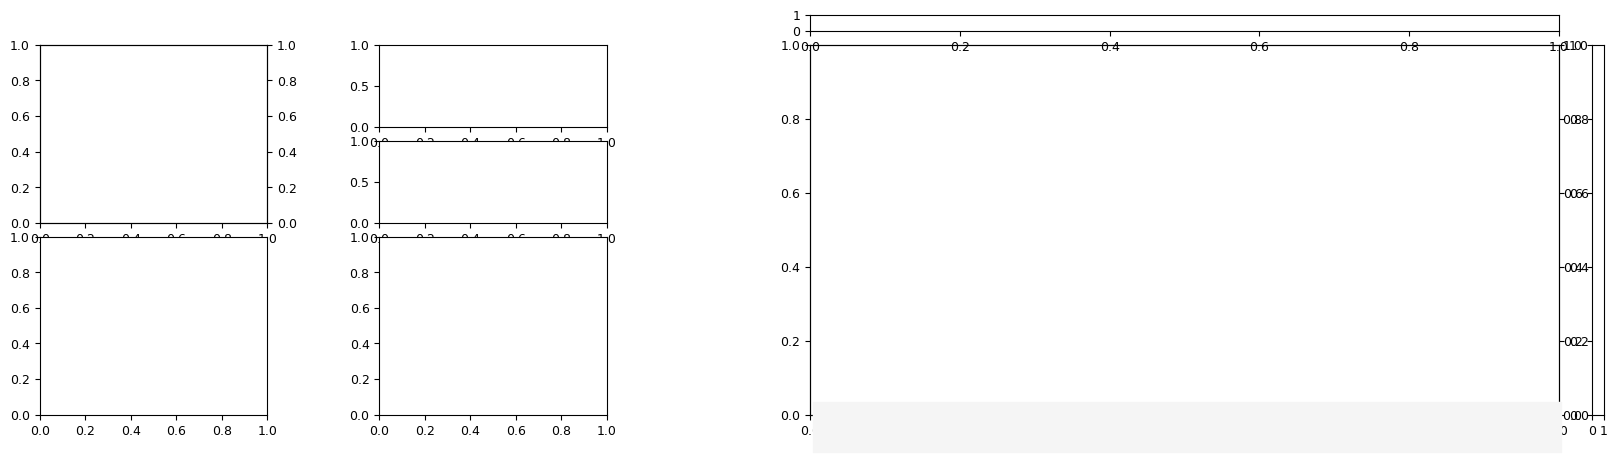

In [18]:
# === LOAD FIGURE ===

#font size and figure parameters :
font_size = 11
params = {
         'legend.title_fontsize': font_size + 2,
         'legend.fontsize': font_size,
         'axes.labelsize': font_size,
         'axes.titlesize':font_size + 2,
         'xtick.labelsize':font_size - 2,
         'ytick.labelsize':font_size - 2,
         'font.size':font_size - 2,
         "axes.titlecolor": "black",
         "axes.labelcolor": "black",
         "xtick.color": "black",
         "ytick.color": "black",
         }
matplotlib.pyplot.rcParams.update(params)

#def des parametres de base:
LFT = True

if LFT == False:
    # == no LFT ==
    # figure structure
    figure = matplotlib.pyplot.figure(figsize=(14, 5))
    figure.tight_layout()
    structure = GridSpec(nrows=5, ncols=6,width_ratios=[1,0.5,1,1,1,0.05], height_ratios=[0.2,1,1,1,1])
    #sub figure
    plot_like = figure.add_subplot(structure[1, 0])
    plot_post = figure.add_subplot(structure[2, 0])
    plot_age = figure.add_subplot(structure[3:, 0])
    plot_history = figure.add_subplot(structure[1:,2:5])
    plot_history_bis = plot_history.twinx()
    plot_timescale = figure.add_subplot(structure[0,2:5],sharex=plot_history)
    plot_hist_legen = figure.add_subplot(structure[1:,5])
else:
    # == LFT ==
    # figure structure
    figure = matplotlib.pyplot.figure(figsize=(17, 5))
    structure = GridSpec(ncols=8, width_ratios=[1,0.2,1,0.6,1,1,1,0.05], nrows=5, height_ratios=[0.2,1,1,1,1])
    figure.tight_layout()
    figure.subplots_adjust(left=0.04,right=0.96,bottom=0.1,top=0.9)
    
    #sub figure
    plot_FT = figure.add_subplot(structure[1:3, 0])
    plot_FT_bis = plot_FT.twinx()
    plot_legend = figure.add_subplot(structure[3:5, 0])
    plot_like = figure.add_subplot(structure[1, 2])
    plot_post = figure.add_subplot(structure[2, 2])
    plot_age = figure.add_subplot(structure[3:, 2])
    plot_history = figure.add_subplot(structure[1:,4:7])
    plot_history_bis = plot_history.twinx()
    plot_timescale = figure.add_subplot(structure[0,4:7],sharex=plot_history)
    plot_hist_legen = figure.add_subplot(structure[1:,7])

#ajout de la zone d'info
x= 0.50
y=0.125
dx=0.12
fond = figure.patches.extend([Rectangle((x-0.005,y),0.44,-0.1,
                                  fill=True, color='whitesmoke', alpha=1, zorder=0,
                                  transform=figure.transFigure, figure=figure)])
inversion_info_1 = figure.text(x,y-0.01, '', color = 'gray', style='italic', multialignment= 'center', verticalalignment='top')
inversion_info_2 = figure.text(x+dx*1,y-0.01, '', color = 'tan', style='italic', multialignment= 'center', verticalalignment='top')
inversion_info_3 = figure.text(x+dx*2,y-0.01, '', color = 'mediumaquamarine', style='italic', multialignment= 'center', verticalalignment='top')
inversion_info_4 = figure.text(x+dx*2.7,y-0.01, '', color = 'palevioletred', style='italic', multialignment= 'center', verticalalignment='top')


In [19]:
# LOAD 'Summary.txt' QTQt DATA FILE and PROCESS IT

def start_process(*, save_format, auto_save_path, classement, hist_color, model, chemin, gradiant, niveau,
                  time_min, time_max, temp_min, temp_max):

    #option list (simple)
    #save_format = '' #'png','svg' (if '' then no save)
    #auto_save_path = False

    #get the file(s) to process
    global filepath
    filepath = get_file(multiple=True)

    for n in range(len(filepath)):
        QTQt_summary = pandas.read_csv(filepath[n], sep='chaineimpossible', engine='python')

        #get/load dictionnary
        global color_list, info_list
        color_list, sample_list = get_colorlist(QTQt_summary)
        info_list = get_inversion_info(QTQt_summary)

        #global variable for re-use
        global tabl_tT_history,tabl_constrain,tabl_tT_pred,tabl_He_like,tabl_He_post,tabl_He_expect,tabl_FT_like,tabl_FT_post, tabl_FT_expect,tabl_LFT
        
        # get data frm the file
        tabl_tT_history = extract_tT_history(QTQt_summary)
        tabl_constrain = extract_constrain(QTQt_summary)
        tabl_tT_pred = extract_tT_pred(QTQt_summary)
        tabl_He_like, tabl_He_post, tabl_He_expect = extract_He_Ages(QTQt_summary)
        tabl_FT_like, tabl_FT_post, tabl_FT_expect = extract_FT_Ages(QTQt_summary)
        tabl_LFT = extract_FT_Length(QTQt_summary)

        # option : time_min=, time_max=, temp_min=, temp_max=, history=True, gradiant=30, surface_t=10, constante=[]
        #         classement='like'/'post'/'iteration', model='like'/'post'/'expect'
        #         niveau= ['Eon', 'Era', 'Period', 'Superepoch', 'Epoch', 'Age']
        plot_iteration(tabl_tT_history, info_list)
        plot_pred_ages(tabl_He_like, tabl_He_post, tabl_He_expect,
                       tabl_FT_like, tabl_FT_post, tabl_FT_expect,
                       color_list, model=model)
        plot_LFT(tabl_LFT, color_list, model=model)
        plot_histoire(tabl_tT_history, tabl_tT_pred, tabl_constrain, classement=classement, color=hist_color,
                      history=chemin, gradiant=gradiant, time_min=time_min, time_max=time_max, temp_min=temp_min, temp_max=temp_max)
        plot_time_scale(tabl_tT_history, niveau=niveau, time_min=time_min, time_max=time_max, temp_min=temp_min, temp_max=temp_max)
        plot_info(info_list)
        add_legende(sample_list, color_list)

        #save
        if save_format != '':
            canvas.setFixedWidth(1700)
            canvas.setFixedHeight(500)
            save_QTQt_fig(filepath[n], save_format, autopath=auto_save_path)

In [20]:
# fonctions declanché par le button principal

def action_button_process():
    
    if combobox_saveformat.currentText() != 'no save':
        save_format = combobox_saveformat.currentText()
    else:
        save_format = ''
        
    if combobox_envelop.currentText() == 'all t(T) paths':
        chemin = True
    else:
        chemin = False       

    if combobox_savedirect.currentText() == 'automatic':
        auto_save_path = True
    else:
        auto_save_path = False
    
    if editbox_minTime.text() != '':
        time_min=float(editbox_minTime.text())
    else:
        time_min=-1
    if editbox_maxTime.text() != '':
        time_max=float(editbox_maxTime.text())
    else:
        time_max=0
    if editbox_minTemp.text() != '':
        temp_min=float(editbox_minTemp.text())
    else:
        temp_min=-1
    if editbox_maxTemp.text() != '':
        temp_max=float(editbox_maxTemp.text())
    else:
        temp_max=0

    try:
        start_process(save_format=save_format, auto_save_path=auto_save_path,
                      classement=combobox_order.currentText(), hist_color = combobox_color.currentText(),
                      model = combobox_prediction.currentText(), chemin = chemin,
                      gradiant = float(editbox_gradient.text()), niveau = combobox_timescale.currentText(),
                      time_min = time_min, time_max = time_max, temp_min= temp_min, temp_max = temp_max
                      )
    #gestion des erreurs
    except ValueError as error:
        error_dialog = QMessageBox()
        error_dialog.setText("Error during the file(s) process" + "\n" + "error : " + str(error))
        error_dialog.exec()
    canvas.draw()
    

In [21]:
# Liste des fonctions declanché par les button secondaire et autre

def action_combo_prediction(text):
    if 'filepath' in globals() :
        plot_pred_ages(tabl_He_like, tabl_He_post, tabl_He_expect,
                       tabl_FT_like, tabl_FT_post, tabl_FT_expect,
                       color_list, model=text)
        plot_LFT(tabl_LFT, color_list, model=text)
        canvas.draw()
        
def action_combo_order(text):
    if 'filepath' in globals() :
        plot_histoire(tabl_tT_history, tabl_tT_pred, tabl_constrain, classement=text, color=combobox_color.currentText())
        canvas.draw()
    
def action_combo_color(text):
    if 'filepath' in globals() :
        plot_histoire(tabl_tT_history, tabl_tT_pred, tabl_constrain, classement=combobox_order.currentText(), color=text)
        canvas.draw()

def action_combo_timescale(text):
    if 'filepath' in globals() :
        plot_time_scale(tabl_tT_history, niveau=combobox_timescale.currentText())
        canvas.draw()

In [22]:
#create the main windows, main widget that will hold the canvas (figure) and other widgets (buttons)
if not QApplication.instance():
    app = QApplication(sys.argv)
else:
    app = QApplication.instance()
window = QMainWindow()
widget = QWidget()
window_layout = QHBoxLayout(widget)


In [23]:
# CANVAS

canvas = FigureCanvasQTAgg(figure)
window.addToolBar(NavigationToolbar(canvas, window))
#size
#canvas.heightForWidth(1/3)

#canvas.setFixedWidth(1700)

#canvas.resize(1700,500)
#canvas.updateGeometry()
#canvas.setFixedHeight(height)


In [24]:
# WIDGETS : Button
button_process = QPushButton("Start")
button_process.clicked.connect(action_button_process)

In [25]:
# WIDGETS : ComboBox

combobox_saveformat = QComboBox()
combobox_saveformat.addItems(["no save", "png", "pdf", "svg"])

combobox_savedirect = QComboBox()
combobox_savedirect.addItems(["automatic", "manual"])

combobox_envelop = QComboBox()
combobox_envelop.addItems(["all t(T) paths", "96% envelop"])

combobox_order = QComboBox()
combobox_order.addItems(["Likelihood", "Posterior", "Iteration"])
combobox_order.currentTextChanged.connect(action_combo_order)

combobox_color = QComboBox()
combobox_color.addItems(["Likelihood", "Posterior"])
combobox_color.currentTextChanged.connect(action_combo_color)

combobox_prediction = QComboBox()
combobox_prediction.addItems(["Max Likelihood", "Max Posterior", "Expected"])
combobox_prediction.currentTextChanged.connect(action_combo_prediction)

combobox_timescale = QComboBox()
combobox_timescale.addItems(["Epoch","Eon", "Era", "Period", "Superepoch", "Age"])
combobox_timescale.currentTextChanged.connect(action_combo_timescale)


In [26]:
# WIDGETS : Editbox

editbox_gradient = QLineEdit()
editbox_gradient.setText("30")

width = 50
editbox_minTime = QLineEdit()
editbox_minTime.setText("")
editbox_minTime.setMaximumWidth(width)
editbox_maxTime = QLineEdit()
editbox_maxTime.setText("")
editbox_maxTime.setMaximumWidth(width)
editbox_minTemp = QLineEdit()
editbox_minTemp.setText("")
editbox_minTemp.setMaximumWidth(width)
editbox_maxTemp = QLineEdit()
editbox_maxTemp.setText("")
editbox_maxTemp.setMaximumWidth(width)


In [27]:
# WIDGETS : Textbox

#font list
font_size = 9
font_header = QFont("Times", font_size + 2, QFont.Bold)
font_info = QFont("Times", font_size, italic=True)

#header
header_1 = QLabel("Saving options :")
header_1.setFont(font_header)
header_2 = QLabel("t(T) paths options :")
header_2.setFont(font_header)
header_3 = QLabel("Other options :")
header_3.setFont(font_header)
header_4 = QLabel("Select and process file(s):")
header_4.setFont(font_header)

#texte
info_10 = QLabel("formats :")
info_10.setFont(font_info)
info_10.setAlignment(Qt.AlignmentFlag.AlignRight)
info_11 = QLabel("destination :")
info_11.setFont(font_info)
info_11.setAlignment(Qt.AlignmentFlag.AlignRight)

info_20 = QLabel("order :")
info_20.setFont(font_info)
info_20.setAlignment(Qt.AlignmentFlag.AlignRight)
info_21 = QLabel("colors :")
info_21.setFont(font_info)
info_21.setAlignment(Qt.AlignmentFlag.AlignRight)
info_22 = QLabel("paths :")
info_22.setFont(font_info)
info_22.setAlignment(Qt.AlignmentFlag.AlignRight)

info_3 = QLabel("Results model :")
info_3.setFont(font_info)
info_3.setAlignment(Qt.AlignmentFlag.AlignRight)
info_4 = QLabel("Gradient [°/km] :")
info_4.setFont(font_info)
info_4.setAlignment(Qt.AlignmentFlag.AlignRight)
info_5 = QLabel("Timescale :")
info_5.setFont(font_info)
info_5.setAlignment(Qt.AlignmentFlag.AlignRight)

info_60 = QLabel("min :")
info_60.setFont(font_info)
info_60.setAlignment(Qt.AlignmentFlag.AlignRight)
info_61 = QLabel("max :")
info_61.setFont(font_info)
info_61.setAlignment(Qt.AlignmentFlag.AlignRight)
info_62 = QLabel("time :")
info_62.setFont(font_info)
info_62.setAlignment(Qt.AlignmentFlag.AlignRight)
info_63 = QLabel("temperature :")
info_63.setFont(font_info)
info_63.setAlignment(Qt.AlignmentFlag.AlignRight)

#space
end = QLabel("")

In [28]:
# WIDGETS POSITIONS 

#colone
action_layout = QVBoxLayout()

#remplissage
action_layout.addWidget(header_1)
split_10 = QHBoxLayout()
split_10.addWidget(info_10)
split_10.addWidget(combobox_saveformat)
action_layout.addLayout(split_10)
split_11 = QHBoxLayout()
split_11.addWidget(info_11)
split_11.addWidget(combobox_savedirect)
action_layout.addLayout(split_11)

action_layout.addWidget(header_2)
split_20 = QHBoxLayout()
split_20.addWidget(info_20)
split_20.addWidget(combobox_order)
action_layout.addLayout(split_20)
split_21 = QHBoxLayout()
split_21.addWidget(info_21)
split_21.addWidget(combobox_color)
action_layout.addLayout(split_21)
split_3 = QHBoxLayout()
split_3.addWidget(info_22)
split_3.addWidget(combobox_envelop)
action_layout.addLayout(split_3)

action_layout.addWidget(header_3)
split_4 = QHBoxLayout()
split_4.addWidget(info_3)
split_4.addWidget(combobox_prediction)
action_layout.addLayout(split_4)
split_5 = QHBoxLayout()
split_5.addWidget(info_5)
split_5.addWidget(combobox_timescale)
action_layout.addLayout(split_5)
split_6 = QHBoxLayout()
split_6.addWidget(info_4)
split_6.addWidget(editbox_gradient)
action_layout.addLayout(split_6)

split_7 = QHBoxLayout()
split_7.addWidget(end)
split_7.addWidget(info_60)
split_7.addWidget(info_61)
action_layout.addLayout(split_7)

split_8 = QHBoxLayout()
split_8.addWidget(info_62)
split_8.addWidget(editbox_minTime)
split_8.addWidget(editbox_maxTime)
action_layout.addLayout(split_8)

split_9 = QHBoxLayout()
split_9.addWidget(info_63)
split_9.addWidget(editbox_minTemp)
split_9.addWidget(editbox_maxTemp)
action_layout.addLayout(split_9)


action_layout.addWidget(end)
action_layout.addWidget(end)
action_layout.addWidget(end)
action_layout.addWidget(end)

action_layout.addWidget(header_4)
action_layout.addWidget(button_process)

In [29]:
# structure the differente wigdet to get to wanted position 
window_layout.addLayout(action_layout)
window_layout.addWidget(canvas)

window.setWindowTitle("QTQt displayer (PyQt V0)")

# Connecter le signal de fermeture à un slot personnalisé
window.closeEvent = lambda event: app.quit()

#Display the Windows
window.setCentralWidget(widget)
window.show()
sys.exit(app.exec_())

C:\Users\Alexis\AppData\Local\Temp\ipykernel_2192\1397625070.py:13: DeprecationWarning: 'exec_' will be removed in the future. Use 'exec' instead.
  sys.exit(app.exec_())
C:\Users\Alexis\AppData\Local\Temp\ipykernel_2192\3666329119.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  files.loc[index,:] = nom_ech[0]


SystemExit: 0

C:\Users\Alexis\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py:3450: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
